# 3 CNN Prediction using secondary structure

The secondary structure of RNA sequences can be predicted from the initial nucleotide sequence. Roughly summarized each nucleotide has a tendency to be paired and has preferences to bind to another nucleotide. These rules can be used to predict based on thermal dynamics the optimal secondary structure. One popular tool to predict the secondary structure in silico is the method "RNAfold" by ViennaRNA ([PubMed](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2447809/)). The secondary structure is usually represented as a dot-bracket notation, which encodes the structure using the ".", "(" and ")" characters, where "." represents an unpaired nucleotide, and a pair of opening and closing brackets encodes two nucleotides, that are paired with each other.

We now have two "channels" of our input (sequence and structure), similarly to how an image has the three RGB channels, we are hoping to see improvements in the prediction, similarly to how an image classifier might have better results when trained on colored pictures instead of grey-scale. We will try to introduce the two channels after first using just the dot-bracket code but also test a the inclusion of a priori knowledge by annotating the dot-bracket code depending on specific patterns of secondary structures like several loops. To this end, the tool [Pysster](https://pubmed.ncbi.nlm.nih.gov/29659719/) uses "RNAfold" for the structure prediction and annotates substructures (F: 5'-end; S: Stem; H: Hairpin Loop; M: Multiloop; I: Internal Loop; and T: 3'-end) based on the dot-bracket notation.

Example:

Nucleotide Sequence

`GTGCCTTTTAAGGCTGATGCAGTGCTTTAAGAGGCTAACACTGAAGGGTAAAGAAAACCATAAAACCCAGAGAAGAGATTGCAAAACTCCTCTTTGAATCCTGTCTGGATTCAAAGCT`

Dot-Bracket Notation

`..((((((((((((.........))))))))))))..........((((...............))))......(((.((....)))))..((((((((((.....))))))))))..`

With a priori knowledge annotated substructures

`FFSSSSSSSSSSSSHHHHHHHHHSSSSSSSSSSSSMMMMMMMMMMSSSSHHHHHHHHHHHHHHHSSSSMMMMMMSSSISSHHHHSSSSSMMSSSSSSSSSSHHHHHSSSSSSSSSSTT`

---

## Read in the data

We want to compare how well we can predict the snoRNA type using the different secondary structure annotations. Let's start by reading in the annotations, you can find them in `snoRNA_secondary_structure.txt`. The file has the following format

`>sequence_id` 

`snorna_type`

`nucleotide sequence`

`dot-bracket-notation`

`structure annotation`

Example:

`>URS000217EFFD_55149`

`HACA-Box`

`GTGCCTTTTAAGGCTGATGCAGTGCTTTAAGAGGCTAACACTGAAGGGTAAAGAAAACCATAAAACCCAGAGAAGAGATTGCAAAACTCCTCTTTGAATCCTGTCTGGATTCAAAGCT`

`..((((((((((((.........))))))))))))..........((((...............))))......(((.((....)))))..((((((((((.....))))))))))..`

`FFSSSSSSSSSSSSHHHHHHHHHSSSSSSSSSSSSMMMMMMMMMMSSSSHHHHHHHHHHHHHHHSSSSMMMMMMSSSISSHHHHSSSSSMMSSSSSSSSSSHHHHHSSSSSSSSSSTT`

## Create a data frame to read in the different sequence information

To read in the data input, create five empty lists to which you can append the entries for each sample. The first list, `id_list`, will be for the sequence IDs, the second list ,`type_list`, will be for the snoRNA type, the third list, `seq_list`, will be for the nucleotide sequences, the fourth list is called `dotbrack_list` and contains the dot-bracket-notation, and lastly, the list `structure_list` is for the sequence of structure annotations. 

We will read the file in, by iterating line by line while having a counter variable count the line we are on. Since there are 5 lines for each entry, we can simply divide the length of the file by 5 and access each sequence by iterating to this number with the variable `i`. the `i`-th line will then be the ID, the `i+1`-th line will be the type, etc. 

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

structure_file = open("snorna_seq_dotbrack_structure.txt")
lines = structure_file.readlines()
n_lines = len(lines)
n_sequences = int(n_lines/5)

id_list = []
type_list = []
seq_list = []
dotbrack_list = []
structure_list = []

# iteration through the file in steps of five
for i in range(n_sequences):
    id_list.append(lines[i*5].strip(">").strip("\n")) 
    type_list.append(lines[i*5+1].strip("\n"))
    seq_list.append(lines[i*5+2].strip("\n"))
    dotbrack_list.append(lines[i*5+3].strip("\n"))
    structure_list.append(lines[i*5+4].strip("\n"))

# Form a dictionary from the lists
struct_dict = {"id": id_list, "type": type_list, "sequence": seq_list, "dot_bracket": dotbrack_list, "structure": structure_list}

# Transform into a DataFrame
struct_df = pd.DataFrame.from_dict(struct_dict)

# Close the file
structure_file.close()
                   
        

In [2]:
struct_df

,id,type,sequence,dot_bracket,structure
0,URS0000A9E1E7_7918,HACA-Box,GCATGGCAATGGATTTATGGTGGGGTCTGCCACATGACCCTTCCAT...,((((((....((((((((((.((((((........)))))).))))...,SSSSSSIIIISSSSSSSSSSISSSSSSHHHHHHHHSSSSSSISSSS...
1,URS000217EFFD_55149,HACA-Box,GTGCCTTTTAAGGCTGATGCAGTGCTTTAAGAGGCTAACACTGAAG...,..((((((((((((.........))))))))))))..........(...,FFSSSSSSSSSSSSHHHHHHHHHSSSSSSSSSSSSMMMMMMMMMMS...
2,URS0000C2E709_407821,HACA-Box,CCTCCTTATTTTGGCACTCTGTCACCTCTGTGGTGATGACGTGAAT...,((((((........(((((.((((((.....)))))))).)))......,SSSSSSIIIIIIIISSSSSISSSSSSHHHHHSSSSSSSSISSSIII...
3,URS0000A9934E_9371,HACA-Box,ATGCTCCAGATTCCTTACCCATCAGACATAAACATTGATCTGAGTG...,.(.((((...((..(((((..(((((((.......)).)))))..)...,FSISSSSIIISSIISSSSSIISSSSSSSHHHHHHHSSISSSSSIIS...
4,URS0000C88F37_225400,HACA-Box,TGCAGCCGTGTCAAATTCGGTGCCTGCCCCCCATGGCAGGCATTGG...,((.(((((((((.....(((((((((((......)))))))))))(...,SSISSSSSSSSSMMMMMSSSSSSSSSSSHHHHHHSSSSSSSSSSSS...
...,...,...,...,...,...
5734,URS0000BD9919_885580,scaRNA,CTTCTTGAGAGGGAGCGTGGCCTGGGGTTGTAGGTGTTCTTGTGCA...,((((((...)))))).((((((((((((.(((((....(((.((((...,SSSSSSHHHSSSSSSMSSSSSSSSSSSSMSSSSSMMMMSSSISSSS...
5735,URS0000BD9A6B_51337,scaRNA,TTTTCTTTTTCTTTTTTTCTGCTCCTCTGTGCCTAGCTCTAACAGG...,........................((((((((((.(((((..((((...,FFFFFFFFFFFFFFFFFFFFFFFFSSSSSSSSSSMSSSSSIISSSS...
5736,URS0000BDA087_10160,scaRNA,ATGCTGTTGACAGAAAGAACGAGCTAATACATTATGATAGTGGGGC...,..((((((.........))).))).....(.((((.((((((((.....,FFSSSSSSHHHHHHHHHSSSISSSMMMMMSISSSSISSSSSSSSII...
5737,URS0000BDA2D9_10036,scaRNA,TATGGAAGCTGCAGAACCAACCATGCAAACAAGTAAAAAACACCTT...,...(((...((((..........))))......................,FFFSSSMMMSSSSHHHHHHHHHHSSSSMMMMMMMMMMMMMMMMMMM...


We will use the same model architecture from before here but feel free to adapt it to your optimized version. 
Our next models will all be tested on the same architecture and the only adjustment from our previous architecture will be the size of the second input dimension (to account for different encodings). 

We will create our CNN model to easily adjust the second input dimension (the number of rows in each one-hot-encoded vector) as an input parameter.

In [3]:
import keras

def create_cnn_model_struct(input_dim_2):

    # create the model
    model = keras.Sequential()

    # You may adapt the parameters to the optimized ones from the last notebook
    model.add(keras.layers.Conv1D(128, 11, activation='relu', padding='same', input_shape=(600, input_dim_2)))
    model.add(keras.layers.MaxPooling1D(4))
    model.add(keras.layers.Dropout(rate = 0.5))
    
    # You may adapt the parameters to the optimized ones from the last notebook
    model.add(keras.layers.Conv1D(64, 7, activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling1D(4))
    model.add(keras.layers.Dropout(rate = 0.5))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(3, activation="softmax"))

    Adam = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Next, we will have to perform the same preprocessing steps for the dot-bracket notation (padding, ordinal encoding, one-hot-encoding)

In [4]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Pad and ordinal encode the dot bracket notation
struct_df["db_pad"] = struct_df.dot_bracket.str.rjust(600, "_")
struct_df["db_pad_ord"] = struct_df.db_pad.map(lambda x: [ord(c) for c in x])

# One-hot encode the dot-bracket
ohe_seq_1 = OneHotEncoder(sparse=False, handle_unknown="ignore")
ohe_seq_1.fit(np.array(struct_df.db_pad_ord[0]).reshape(-1, 1))
struct_df["db_ohe"] = struct_df.db_pad_ord.map(lambda x: ohe_seq_1.transform(np.array(x).reshape(-1,1)))

We will need numbers again after this. Set the seed to the same number as in the previous notebook in the following cell. We will use the same random seed for the entire notebook, so don't change it again after setting it once. 

In [5]:
random = 1896

Split into train and test

In [6]:
from sklearn.model_selection import train_test_split

# Split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(struct_df[["db_ohe"]], struct_df["type"], test_size=0.15, random_state=random, stratify=struct_df["type"])

Encode the labels

In [7]:
# One hot encode the labels
ohe = OneHotEncoder(sparse=False)  # Create an instance of the OneHotEncoder class. sparse=True would be useful for instances with a lot of different labels, but for us we don't need it
ohe.fit(np.array(Y_train).reshape(-1, 1))  # Fit the encoder to our data
Y_train_ohe = ohe.transform(np.array(Y_train).reshape(-1, 1))  # Transform the training labels
Y_test_ohe = ohe.transform(np.array(Y_test).reshape(-1, 1))  # Transform the test labels

Transform input into arrays. Since there are four different characters, `.`, `(`, `)` and `_`, the second dimension will be four.  

In [8]:
# Turn train and test input into arrays
X_train_db_array = np.array(X_train.db_ohe.to_list()).reshape(len(X_train), 600, 4)
X_test_db_array = np.array(X_test.db_ohe.to_list()).reshape(len(X_test), 600, 4)

Investigate the prediction accuracy of the dot-bracket CNN model.

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create and fit the model to the train data
model = create_cnn_model_struct(input_dim_2=4)  # Set the input dim to the length of our OneHotEncoded vectors
model.fit(X_train_db_array, Y_train_ohe, epochs=40, batch_size=40, verbose=2, validation_split=0.15, callbacks = [callback])

# Predict the test data and transform the prediction to labels
pred = model.predict(X_test_db_array)
pred_labels_db = ohe.inverse_transform(pred)

# Save scores for plotting
f1_db = f1_score(Y_test, pred_labels_db, average="weighted")
prec_db = precision_score(Y_test, pred_labels_db, average="weighted")
rec_db = recall_score(Y_test, pred_labels_db, average="weighted")

# Print classification report
print(classification_report(Y_test, pred_labels_db, digits=4))

Epoch 1/40
104/104 - 16s - loss: 0.8012 - accuracy: 0.6261 - val_loss: 0.6704 - val_accuracy: 0.6995 - 16s/epoch - 153ms/step
Epoch 2/40
104/104 - 15s - loss: 0.6668 - accuracy: 0.6954 - val_loss: 0.6037 - val_accuracy: 0.7500 - 15s/epoch - 147ms/step
Epoch 3/40
104/104 - 15s - loss: 0.6197 - accuracy: 0.7315 - val_loss: 0.5762 - val_accuracy: 0.7541 - 15s/epoch - 149ms/step
Epoch 4/40
104/104 - 15s - loss: 0.5912 - accuracy: 0.7446 - val_loss: 0.5606 - val_accuracy: 0.7609 - 15s/epoch - 147ms/step
Epoch 5/40
104/104 - 15s - loss: 0.5844 - accuracy: 0.7492 - val_loss: 0.5542 - val_accuracy: 0.7691 - 15s/epoch - 147ms/step
Epoch 6/40
104/104 - 15s - loss: 0.5574 - accuracy: 0.7631 - val_loss: 0.5278 - val_accuracy: 0.7869 - 15s/epoch - 147ms/step
Epoch 7/40
104/104 - 15s - loss: 0.5590 - accuracy: 0.7588 - val_loss: 0.5287 - val_accuracy: 0.7869 - 15s/epoch - 147ms/step
Epoch 8/40
104/104 - 15s - loss: 0.5437 - accuracy: 0.7759 - val_loss: 0.5165 - val_accuracy: 0.7842 - 15s/epoch - 147

Let's free up some space.

In [11]:
import gc

del X_train_db_array, X_test_db_array

gc.collect()

2304

Next we want to train on the structure string and compare it to the results from the dot-bracket string.

The steps will be the same, padding, ordinal encoding, one-hot encoding, train/test splitting and transforming into an array. 

In [12]:
struct_df["struct_pad"] = struct_df.structure.str.rjust(600, "_")
struct_df["struct_pad_ord"] = struct_df.struct_pad.map(lambda x: [ord(c) for c in x])

ohe_seq_2 = OneHotEncoder(sparse=False, handle_unknown="ignore")
ohe_seq_2.fit(np.array(struct_df.struct_pad_ord[0]).reshape(-1, 1))
struct_df["struct_ohe"] = struct_df.struct_pad_ord.map(lambda x: ohe_seq_2.transform(np.array(x).reshape(-1,1)))

X_train, X_test, Y_train, Y_test = train_test_split(struct_df[["struct_ohe"]], struct_df["type"], test_size=0.15, random_state=random, stratify=struct_df["type"])
X_train_struct_array = np.array(X_train.struct_ohe.to_list()).reshape(len(X_train), 600, 6)
X_test_struct_array = np.array(X_test.struct_ohe.to_list()).reshape(len(X_test), 600, 6)

**What is the better approach to solve our problem?**

In [13]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create and fit the model to the train data
model = create_cnn_model_struct(input_dim_2=6)
model.fit(X_train_struct_array, Y_train_ohe, epochs=50, batch_size=40, verbose=2, validation_split=0.15, callbacks = [callback])

# Predict the test set then turn the prediction into labels
pred = model.predict(X_test_struct_array)
pred_labels_structure = ohe.inverse_transform(pred)

# Save scores for plotting
f1_structure = f1_score(Y_test, pred_labels_structure, average="weighted")
prec_structure = precision_score(Y_test, pred_labels_structure, average="weighted")
rec_structure = recall_score(Y_test, pred_labels_structure, average="weighted")

# Print classification report
print(classification_report(Y_test, pred_labels_structure, digits=2))

Epoch 1/50
104/104 - 16s - loss: 0.8125 - accuracy: 0.6254 - val_loss: 0.6828 - val_accuracy: 0.7363 - 16s/epoch - 157ms/step
Epoch 2/50
104/104 - 16s - loss: 0.6605 - accuracy: 0.7096 - val_loss: 0.6012 - val_accuracy: 0.7582 - 16s/epoch - 151ms/step
Epoch 3/50
104/104 - 16s - loss: 0.6122 - accuracy: 0.7306 - val_loss: 0.5630 - val_accuracy: 0.7705 - 16s/epoch - 153ms/step
Epoch 4/50
104/104 - 16s - loss: 0.5870 - accuracy: 0.7501 - val_loss: 0.5520 - val_accuracy: 0.7705 - 16s/epoch - 152ms/step
Epoch 5/50
104/104 - 16s - loss: 0.5691 - accuracy: 0.7542 - val_loss: 0.5322 - val_accuracy: 0.7801 - 16s/epoch - 154ms/step
Epoch 6/50
104/104 - 16s - loss: 0.5469 - accuracy: 0.7687 - val_loss: 0.5236 - val_accuracy: 0.8005 - 16s/epoch - 152ms/step
Epoch 7/50
104/104 - 16s - loss: 0.5337 - accuracy: 0.7619 - val_loss: 0.5118 - val_accuracy: 0.7910 - 16s/epoch - 152ms/step
Epoch 8/50
104/104 - 16s - loss: 0.5154 - accuracy: 0.7849 - val_loss: 0.4987 - val_accuracy: 0.7883 - 16s/epoch - 152

# Integrating the nucleotide sequence to the structural information

In Multi-Omics analysis there is a concept of so called [data integration](https://www.researchgate.net/publication/358074725_Machine_learning_for_multi-omics_data_integration_in_cancer) to combine several  molecular levels (e.g. Transcriptomics, Proteomics) to train a ML classifier to detect pattern over several molecular layers. Obviously, we are not dealing with Omics datasets in this example but still the concept of data integration can be transfered to our biological problem. 

We would like to integrate different input levels (sequence and strcuture) into one model. This can be approached by "early" or "late" integration.

Early Integration refers to the practice of combining several layer of inputs already in the beginning in our case before adding it to the model. 

We do that by creating an arbitrary encoding of the nucleotide sequence combined with the structural sequence information. Therefore we need to create a function that encodes the sequence the following way: Every combination of nucleotide (A, C, G, T) and structure (F, S, I, M, H, T) is encoded as its own letter. If there are any other letters we encode the combination as "N".

||F|S|I|M|H|T|
|---|---|---|---|---|---|---|
|**A**|Q|W|E|R|T|Z|
|**C**|U|I|O|P|A|S|
|**G**|D|F|G|H|J|K|
|**T**|L|Y|X|C|V|B|
|**other**|N|N|N|N|N|N|

In [14]:
def struct_annotator(sequence, structure):
    if (len(sequence) != len(structure)):
        print("Sequence and structure not of equal length")
    else:
        # Create empty string that we can append the encoding to for each sequence
        annotated_struct = ""
        
        #Assignment of letters for combinations
        dic = {"A": ["Q", "W", "E", "R", "T", "Z"],
               "C": ["U", "I", "O", "P", "A", "S"],
               "G": ["D", "F", "G", "H", "J", "K"],
               "T": ["L", "Y", "X", "C", "V", "B"],
               "other": ["N", "N", "N", "N", "N", "N"]}
        # Save into a df, such that we can access nucleotide by column and structure by index
        df = pd.DataFrame(dic, index = ["F", "S", "I", "M", "H", "T"])
        
        for i in range(0, len(sequence)):
            
            # Annotate according to the nucleotide
            if (sequence[i] in ["A", "C", "G", "T"]):
                # Append the structure with the correct letter
                annotated_struct = annotated_struct + df[sequence[i]][structure[i]]
                
            # Annotate if unknown IUPAC ambiguity code is found
            else:
                annotated_struct = annotated_struct + df["other"][structure[i]]
    return(annotated_struct)

Let's apply our function to every sequence in our dataframe

In [15]:
# Create new column for our sequence/structure mix
struct_df["seq_struct"] = ""

# Fill column with our function
for i in range(len(struct_df)):
    struct_df["seq_struct"][i] = struct_annotator(struct_df["sequence"][i], struct_df["structure"][i])

Now the same preprocessing steps from before

In [16]:
struct_df["seq_struct_pad"] = struct_df["seq_struct"].str.rjust(600, "_")  # Padding
struct_df["seq_struct_pad_ord"] = struct_df["seq_struct_pad"].map(lambda x: [ord(c) for c in x])  # Ordinal Encoding

ohe_seq_3 = OneHotEncoder(sparse=False, handle_unknown="ignore")  # Creating a new One-Hot Encoder
ohe_seq_3.fit(np.array(struct_df["seq_struct_pad_ord"][0]).reshape(-1, 1))  # Fit the OHE to the new input
struct_df["seq_struct_ohe"] = struct_df["seq_struct_pad_ord"].map(lambda x: ohe_seq_3.transform(np.array(x).reshape(-1,1)))  # Transform to the one-hot encoded input

# Split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(struct_df[["seq_struct_ohe"]], struct_df["type"], test_size=0.15, random_state=random, stratify=struct_df["type"])

# Transform input into arrays
X_train_seq_struct_array = np.array(X_train["seq_struct_ohe"].to_list()).reshape(len(X_train), 600, 19)  # Turn into an array
X_test_seq_struct_array = np.array(X_test["seq_struct_ohe"].to_list()).reshape(len(X_test), 600, 19)  # Turn into an array

Let's run our early integration model

In [17]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create and fit the model
model = create_cnn_model_struct(input_dim_2=19)
model.fit(X_train_seq_struct_array, Y_train_ohe, epochs=150, batch_size=40, verbose=2, validation_split=0.15, callbacks=[callback])

# Predict test set, then transform back into labels
pred = model.predict(X_test_seq_struct_array)
pred_labels_early_int = ohe.inverse_transform(pred)

# Save the scores for later visualization
f1_early_int = f1_score(Y_test, pred_labels_early_int, average="weighted")
prec_early_int = precision_score(Y_test, pred_labels_early_int, average="weighted")
rec_early_int = recall_score(Y_test, pred_labels_early_int, average="weighted")

# Print Classification Report
print(classification_report(Y_test, pred_labels_early_int, digits=2))

Epoch 1/150
104/104 - 20s - loss: 0.7798 - accuracy: 0.6474 - val_loss: 0.6013 - val_accuracy: 0.8115 - 20s/epoch - 194ms/step
Epoch 2/150
104/104 - 20s - loss: 0.5387 - accuracy: 0.7998 - val_loss: 0.4537 - val_accuracy: 0.8648 - 20s/epoch - 192ms/step
Epoch 3/150
104/104 - 20s - loss: 0.4299 - accuracy: 0.8418 - val_loss: 0.3724 - val_accuracy: 0.8839 - 20s/epoch - 196ms/step
Epoch 4/150
104/104 - 20s - loss: 0.3797 - accuracy: 0.8620 - val_loss: 0.3120 - val_accuracy: 0.8948 - 20s/epoch - 194ms/step
Epoch 5/150
104/104 - 20s - loss: 0.3199 - accuracy: 0.8799 - val_loss: 0.2836 - val_accuracy: 0.9030 - 20s/epoch - 194ms/step
Epoch 6/150
104/104 - 20s - loss: 0.2836 - accuracy: 0.9004 - val_loss: 0.2517 - val_accuracy: 0.9112 - 20s/epoch - 196ms/step
Epoch 7/150
104/104 - 20s - loss: 0.2414 - accuracy: 0.9170 - val_loss: 0.2364 - val_accuracy: 0.9235 - 20s/epoch - 195ms/step
Epoch 8/150
104/104 - 20s - loss: 0.2259 - accuracy: 0.9199 - val_loss: 0.2333 - val_accuracy: 0.9139 - 20s/epo

In [18]:
del X_train_seq_struct_array, X_test_seq_struct_array

gc.collect()

7277

The Late Integration is in practice the training and optimization of several models in parallel and combining the outputs of both in one layer before the final prediction. In our case the models are  concatenated at the "head" (before the output) and create some kind of consens prediction. The advantage is to not create a specific encoding as each input sample consists of one nucleotide sequence and one structure sequence. 

Within the same function, we will create two times the same models, just varying the input to be structural (annotated structure sequence) or sequence (nucleotides). Each model will have a dense ReLU layer with 10 nodes instead of the original output layer. The last layer of each model will be concatenated using keras [Concatenate](https://keras.io/api/layers/merging_layers/concatenate/) layer. After the concatenation we add the output (but it could make sense to add more dense layers to learn from the combination of the single outputs). 

Note, that this model has roughly twice as many parameters than the Early Integration model, so training might take longer and results will probably be different.

In [19]:
def create_model_late_integration():
    
    #Sequence Model
    seq_model = keras.Sequential()

    seq_model.add(keras.layers.Conv1D(128, 11, activation='relu', padding='same', input_shape=(600, 5)))
    seq_model.add(keras.layers.MaxPooling1D(4))
    seq_model.add(keras.layers.Dropout(rate = 0.5))

    seq_model.add(keras.layers.Conv1D(64, 7, activation='relu', padding='same'))
    seq_model.add(keras.layers.MaxPooling1D(4))
    seq_model.add(keras.layers.Dropout(rate = 0.5))

    seq_model.add(keras.layers.Flatten())
    seq_model.add(keras.layers.Dense(10, activation='relu'))
    
    #Structure Model
    struct_model = keras.Sequential()

    struct_model.add(keras.layers.Conv1D(128, 11, activation='relu', padding='same', input_shape=(600, 6)))
    struct_model.add(keras.layers.MaxPooling1D(4))
    struct_model.add(keras.layers.Dropout(rate = 0.5))

    struct_model.add(keras.layers.Conv1D(64, 7, activation='relu', padding='same'))
    struct_model.add(keras.layers.MaxPooling1D(4))
    struct_model.add(keras.layers.Dropout(rate = 0.5))

    struct_model.add(keras.layers.Flatten())
    struct_model.add(keras.layers.Dense(10, activation='relu'))
    
    #Merging the models
    concatenated = keras.layers.Concatenate()([seq_model.output, struct_model.output])
    concatenated = keras.layers.Dense(3, activation = "softmax", name = "output_layer")(concatenated)
    final_model = keras.Model([seq_model.input, struct_model.input], concatenated)
    
    Adam = keras.optimizers.Adam(learning_rate=0.001)
    final_model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    del struct_model, seq_model
    return(final_model)


We have first to create again the sequence information for the input from Notebook 2.

In [20]:
# Padding and ordinal encoding
struct_df["seq_pad"] = struct_df["sequence"].str.rjust(600, "_")
struct_df["seq_pad_ord"] = struct_df["seq_pad"].map(lambda x: [ord(c) for c in x])

# one-hot encoding
ohe_seq_4 = OneHotEncoder(sparse=False, handle_unknown="ignore")
ohe_seq_4.fit(np.array(struct_df["seq_pad_ord"][0]).reshape(-1, 1))
struct_df["seq_ohe"] = struct_df["seq_pad_ord"].map(lambda x: ohe_seq_4.transform(np.array(x).reshape(-1,1)))

# Create train test split
X_train, X_test, Y_train, Y_test = train_test_split(struct_df[["seq_ohe"]], struct_df["type"], test_size=0.15, random_state=random, stratify=struct_df["type"])

# Transform into arrays
X_train_seq_array = np.array(X_train["seq_ohe"].to_list()).reshape(len(X_train), 600, 5)
X_test_seq_array = np.array(X_test["seq_ohe"].to_list()).reshape(len(X_test), 600, 5)

Now we are ready to train. Since we have the two different inputs, we enter the training and test data in a list: `[X_train_seq_array, X_train_struct_array]`

In [21]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create and fit the model
model = create_model_late_integration()
model.fit([X_train_seq_array, X_train_struct_array], Y_train_ohe, epochs=150, batch_size=40, verbose=2, validation_split=0.15, callbacks=[callback])

# Predict the test set and transform the prediction to labels
pred = model.predict([X_test_seq_array, X_test_struct_array])
pred_labels_late_int = ohe.inverse_transform(pred)

# Save scores for plotting
f1_late_int = f1_score(Y_test, pred_labels_late_int, average="weighted")
prec_late_int = precision_score(Y_test, pred_labels_late_int, average="weighted")
rec_late_int = recall_score(Y_test, pred_labels_late_int, average="weighted")

# Print classification report
print(classification_report(Y_test, pred_labels_late_int, digits=2))

Epoch 1/150
104/104 - 33s - loss: 0.7621 - accuracy: 0.6667 - val_loss: 0.5972 - val_accuracy: 0.8306 - 33s/epoch - 315ms/step
Epoch 2/150
104/104 - 32s - loss: 0.5142 - accuracy: 0.7998 - val_loss: 0.4147 - val_accuracy: 0.8730 - 32s/epoch - 310ms/step
Epoch 3/150
104/104 - 33s - loss: 0.3914 - accuracy: 0.8529 - val_loss: 0.3271 - val_accuracy: 0.8921 - 33s/epoch - 313ms/step
Epoch 4/150
104/104 - 32s - loss: 0.3433 - accuracy: 0.8710 - val_loss: 0.2976 - val_accuracy: 0.8989 - 32s/epoch - 311ms/step
Epoch 5/150
104/104 - 32s - loss: 0.2918 - accuracy: 0.8944 - val_loss: 0.2594 - val_accuracy: 0.9153 - 32s/epoch - 312ms/step
Epoch 6/150
104/104 - 33s - loss: 0.2620 - accuracy: 0.9064 - val_loss: 0.2206 - val_accuracy: 0.9208 - 33s/epoch - 313ms/step
Epoch 7/150
104/104 - 32s - loss: 0.2269 - accuracy: 0.9214 - val_loss: 0.2214 - val_accuracy: 0.9262 - 32s/epoch - 312ms/step
Epoch 8/150
104/104 - 32s - loss: 0.2076 - accuracy: 0.9293 - val_loss: 0.1927 - val_accuracy: 0.9385 - 32s/epo

<AxesSubplot: >

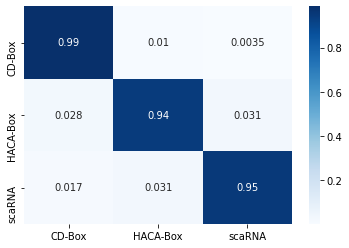

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
conf_matrix = confusion_matrix(Y_test, pred_labels_late_int, normalize="true")

# Transform into a dataframe
conf_df = pd.DataFrame(conf_matrix, index=["CD-Box", "HACA-Box", "scaRNA"], columns=["CD-Box", "HACA-Box", "scaRNA"])

# Plot heatmap
sns.heatmap(conf_df, annot=True, cmap="Blues")

As a final visualization we can now compare the influence of the different inputs and combinations.

<AxesSubplot: xlabel='variable', ylabel='value'>

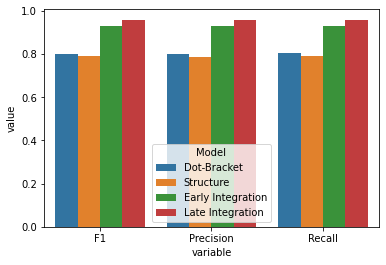

In [23]:
# Create Dictionary with all scores
dictionary = {"F1": [f1_db, f1_structure, f1_early_int, f1_late_int],
              "Precision": [prec_db, prec_structure, prec_early_int, prec_late_int],
              "Recall": [rec_db, rec_structure, rec_early_int, rec_late_int],
              "Model": ["Dot-Bracket", "Structure", "Early Integration", "Late Integration"]}

# Save them into a dataframe
df = pd.DataFrame(dictionary)
df = pd.melt(df, id_vars=["Model"])

# Plot the scores using a barplot
sns.barplot(data=df, x="variable", y="value", hue="Model")

**What input seems to perform best? Is the combination/integration giving better results?**